In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()

from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *

# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D

# import external libs
import cv2
import pandas as pd

# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

EXPERIMENT = 'temp/MotionGenerator-tests'

# ------------------------------------------generator hyperparameters
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 2 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
DIM = [30, 64, 64] # network input params for spacing of 3, (z,y,x)
SPACING = [4, 4, 4] # if resample, resample to this spacing, (z,y,x)
# maybe we can drop this channel?
#IMG_CHANNELS = 1 # Currently our model needs that image channel
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
MASKING_IMAGE = True
MASKING_VALUES = [2]
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 1
SHUFFLE = True
RESAMPLE = True
SCALER = 'Standard' # MinMax Standard or Robust

Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-04-27 17:21:31,369 INFO -------------------- Start --------------------
2021-04-27 17:21:31,369 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-04-27 17:21:31,370 INFO Log file: ./logs/temp/MotionGenerator-tests.log
2021-04-27 17:21:31,370 INFO Log level for console: INFO


{'__K': None, 'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/MotionGenerator-tests', 'BATCHSIZE': 2, 'GENERATOR_WORKER': 2, 'DIM': [30, 64, 64], 'SPACING': [4, 4, 4], 'MASK_VALUES': [1, 2, 3], 'MASK_CLASSES': 3, 'MASKING_IMAGE': True, 'MASKING_VALUES': [2], 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INTERPOLATION': 0, 'AUGMENT': True, 'AUGMENT_PROB': 1, 'SHUFFLE': True, 'RESAMPLE': True, 'SCALER': 'Standard', 'CONFIG_PATH': 'reports/config/temp/MotionGenerator-tests', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/temp/MotionGenerator-tests', 'MODEL_PATH': 'models/temp/MotionGenerator-tests', 'HISTORY_PATH': 'reports/history/temp/MotionGenerator-tests'}


In [2]:
######################################
# for fast tests, no choice
path_to_df = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase_outcome_meta_bsa'
df = pd.read_csv(path_to_df)
df['phase'] = pd.Categorical(df.phase, 
                      categories=['ED','MS','ES','PF','MD'],
                      ordered=True)
#print(df.info())
#######################################

# load the dataframe
from ipyfilechooser import FileChooser
df_chooser = FileChooser('/mnt/ssd/data/gcn/02_imported_4D_unfiltered/')
display(df_chooser)
@interact_manual
def load_df():
    global df
    if df_chooser.selected is not None:
        path_to_df  = df_chooser.selected
        df = pd.read_csv(path_to_df)
        df['phase'] = pd.Categorical(df.phase, 
                              categories=['ED','MS','ES','PF','MD'],
                              ordered=True)
        #print(df.describe())
        print(df.info())

FileChooser(path='/mnt/ssd/data/gcn/02_imported_4D_unfiltered', filename='', title='HTML(value='', layout=Layo…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [3]:
# check internally if there are two columns for the patient ID, the original row from the Excel-Sheet had errors
print(df[['patient', 'PatientID']][df.PatientID != df.patient])
# extract the files for all phases
df_phases = df[['patient','x_path', 'phase']]
df_phases

      patient PatientID
5    04NEJQUZ  04NEJQU7
6    04NEJQUZ  04NEJQU7
7    04NEJQUZ  04NEJQU7
8    04NEJQUZ  04NEJQU7
9    04NEJQUZ  04NEJQU7
640  GZH20326  6ZH20326
641  GZH20326  6ZH20326
642  GZH20326  6ZH20326
643  GZH20326  6ZH20326
644  GZH20326  6ZH20326
890  PEXM9GEK  PEXM9GE 
891  PEXM9GEK  PEXM9GE 
892  PEXM9GEK  PEXM9GE 
893  PEXM9GEK  PEXM9GE 
894  PEXM9GEK  PEXM9GE 


,patient,x_path,phase
0,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,MS
1,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,ES
2,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,PF
3,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,MD
4,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,ED
...,...,...,...
1320,ZZQ0001Q,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,ED
1321,ZZQ0001Q,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,MS
1322,ZZQ0001Q,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,ES
1323,ZZQ0001Q,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,PF


In [4]:
# zip the phase files in the following structure:
#[[patient1_phase1, patient1_phase2, patient1_phase3, patient1_phase4, patient1_phase5],[patient2_phase1...] ...]

ed = df_phases[df_phases['phase'] == 'ED']['x_path']
ms = df_phases[df_phases['phase'] == 'MS']['x_path']
es = df_phases[df_phases['phase'] == 'ES']['x_path']
pf = df_phases[df_phases['phase'] == 'PF']['x_path']
md = df_phases[df_phases['phase'] == 'MD']['x_path']

# zip the phase list into one list of lists/tuples
inputs = list(zip(ed,ms,es,pf,md))
outputs = list(zip(ms,es,pf,md,ed))

In [5]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import MotionDataGenerator
config['AUGMENT'] = True
config['RESAMPLE'] = True
batch_generator = MotionDataGenerator(inputs, outputs, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
validation_generator = MotionDataGenerator(inputs, outputs , config=val_config)

2021-04-27 17:21:31,650 INFO Create DataGenerator
2021-04-27 17:21:31,655 INFO Datagenerator created with: 
 shape: [30, 64, 64]
 spacing: [4, 4, 4]
 batchsize: 2
 Scaler: Standard
 Images: 265 
 Augment: True 
 Thread workers: 2
2021-04-27 17:21:31,656 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-04-27 17:21:31,656 INFO Create DataGenerator
2021-04-27 17:21:31,661 INFO Datagenerator created with: 
 shape: [30, 64, 64]
 spacing: [4, 4, 4]
 batchsize: 2
 Scaler: Standard
 Images: 265 
 Augment: False 
 Thread workers: 2
2021-04-27 17:21:31,662 INFO No augmentation


In [6]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(batch_generator), 1), im = (0,BATCHSIZE- 1, 1), slice_n=(1,11), save=False, filepath='data/temp/', filename='temp_x.npy'):
    
    import time
    global inputs, outputs
    t1 = time.time()
    inputs, outputs = batch_generator.__getitem__(batch)
    if type(inputs)==list:inputs, outputs = inputs[0], outputs[0]
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    
    selected_input = inputs[im]
    selected_output = outputs[im]
    
    list(map(lambda x: show_2D_or_3D(img=x[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_input))
    plt.show()
    info('-'*100)
    #list(map(lambda x: show_2D_or_3D(img=x[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_output))
    
    """
        show_2D_or_3D(x[im], y[im], interpol='bilinear',dpi=100,f_size=(5,5))
    plt.show()
    """
    plt.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
    plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=66, description='batch', max=132), IntSlider(value=0, description='im', …

In [7]:
from src.models.Models import create_RegistrationModel

import tensorflow

if tensorflow.distribute.has_strategy():
    strategy = tensorflow.distribute.get_strategy()
else:
    # distribute the training with the "mirrored data"-paradigm across multiple gpus if available, if not use gpu 0
    strategy = tensorflow.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
with strategy.scope():
    model = create_RegistrationModel(config=config)

using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2021-04-27 17:21:32,539 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


(None, 30, 64, 64, 1)
(None, 30, 64, 64, 1)
Instructions for updating:
Use fn_output_signature instead


2021-04-27 17:21:33,763 WARNING From /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:574: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


In [8]:
model.summary()

Model: "simpleregister"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 30, 64, 6 0                                            
__________________________________________________________________________________________________
tf_op_layer_unstack (TensorFlow [(None, 30, 64, 64,  0           input_1[0][0]                    
__________________________________________________________________________________________________
unet (Functional)               (None, 30, 64, 64, 1 6471776     tf_op_layer_unstack[0][3]        
                                                                 tf_op_layer_unstack[0][1]        
                                                                 tf_op_layer_unstack[0][2]        
                                                                 tf_op_layer_unstack[

In [10]:
import tensorflow
from src.utils.Metrics import Grad, MSE_
if 'strategy' in locals():
    pass
else:
    # distribute the training with the "mirrored data"-paradigm across multiple gpus if available, if not use gpu 0
    strategy = tensorflow.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
with strategy.scope():

    losses = [MSE_(0.02).loss, Grad('l2').loss]
    weights = [1,0.01]
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.1), loss=losses, loss_weights=weights)

In [11]:
results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=2,
    #callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=0,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

Epoch 1/2
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


2021-04-27 17:22:00,174 WARNING From /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/data/ops/multi_device_iterator_ops.py:601: get_next_as_optional (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1


2021-04-27 17:22:07,035 INFO batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:07,402 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:07,405 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:07,408 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:07,410 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:07,413 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:07,416 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1


2021-04-27 17:22:15,962 INFO batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:16,223 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:16,227 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:16,231 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-04-27 17:22:16,234 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


132/132 [==============================] - 66s 500ms/step - loss: nan - tf_op_layer_stack_loss: 2539.5530 - tf_op_layer_stack_1_loss: nan - val_loss: nan - val_tf_op_layer_stack_loss: 2528.4924 - val_tf_op_layer_stack_1_loss: nan
Epoch 2/2
132/132 [==============================] - 63s 475ms/step - loss: nan - tf_op_layer_stack_loss: 2535.9924 - tf_op_layer_stack_1_loss: nan - val_loss: nan - val_tf_op_layer_stack_loss: 2528.4016 - val_tf_op_layer_stack_1_loss: nan


In [14]:
pred = model.predict(x=batch_generator)

In [15]:
transformed, flow = pred
print(transformed.shape)
print(flow.shape)

(264, 5, 30, 64, 64, 1)
(264, 5, 30, 64, 64, 3)


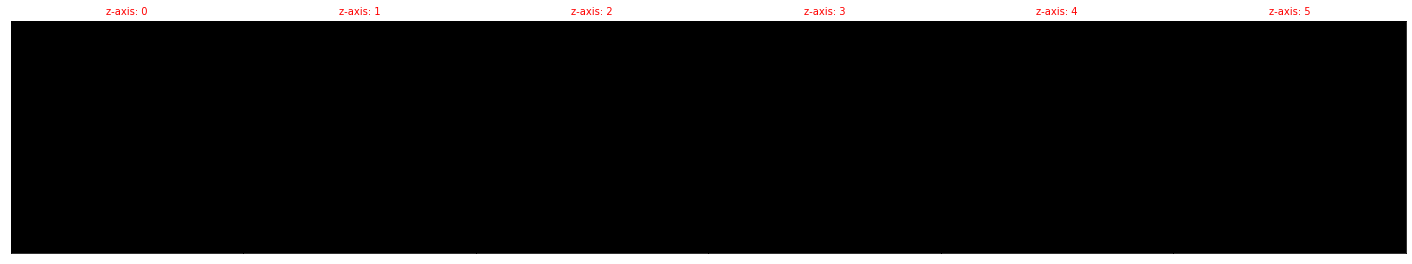

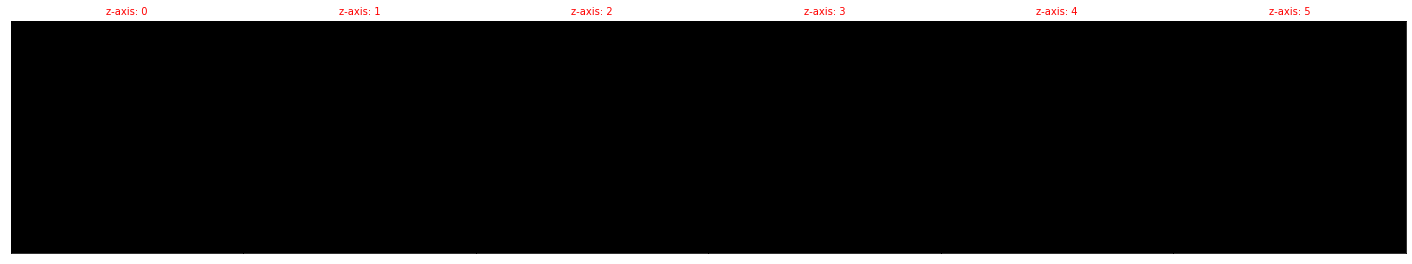

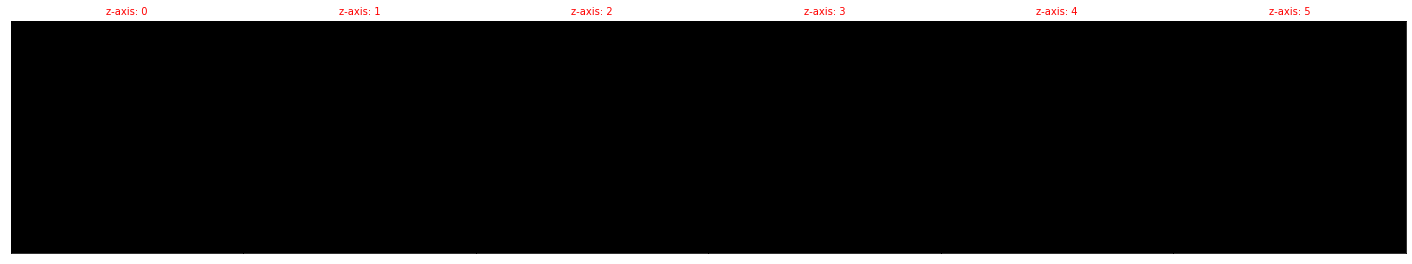

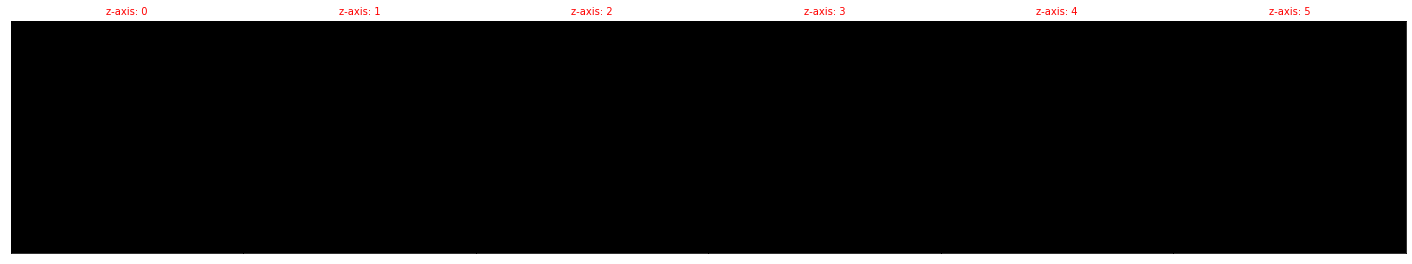

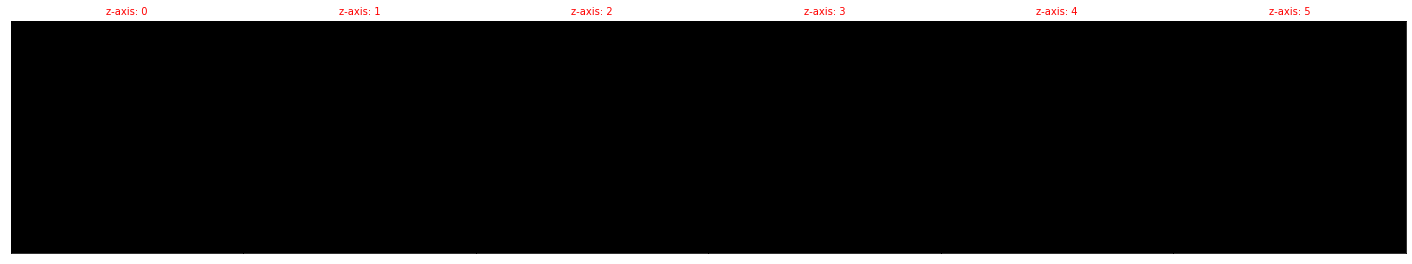

In [17]:
temp = transformed[0]
list(map(lambda x: show_2D_or_3D(img=x[::5], interpol='bilinear',dpi=100,f_size=(5,5)), temp))
plt.show()